In [28]:
from mpl_toolkits import mplot3d
# %matplotlib inline
%matplotlib notebook
import numpy as np
import os
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [29]:
root_dir = '/Users/poodarchu/Desktop/KITTI_teaser'
example_id = '007480'
raw_lidar = np.fromfile(os.path.join(root_dir, 'velodyne/'+example_id+'.bin'), dtype=np.float32).reshape((-1,4))
# raw_lidar = np.fromfile("/home/users/benjin.zhu/1542617253237.bin", dtype=np.float32).reshape(-1, 4)

In [30]:
raw_lidar.shape

(110736, 4)

In [31]:
xdata = raw_lidar[:,0]
ydata = raw_lidar[:,1]
zdata = raw_lidar[:,2]
idata = raw_lidar[:,3]

<IPython.core.display.Javascript object>


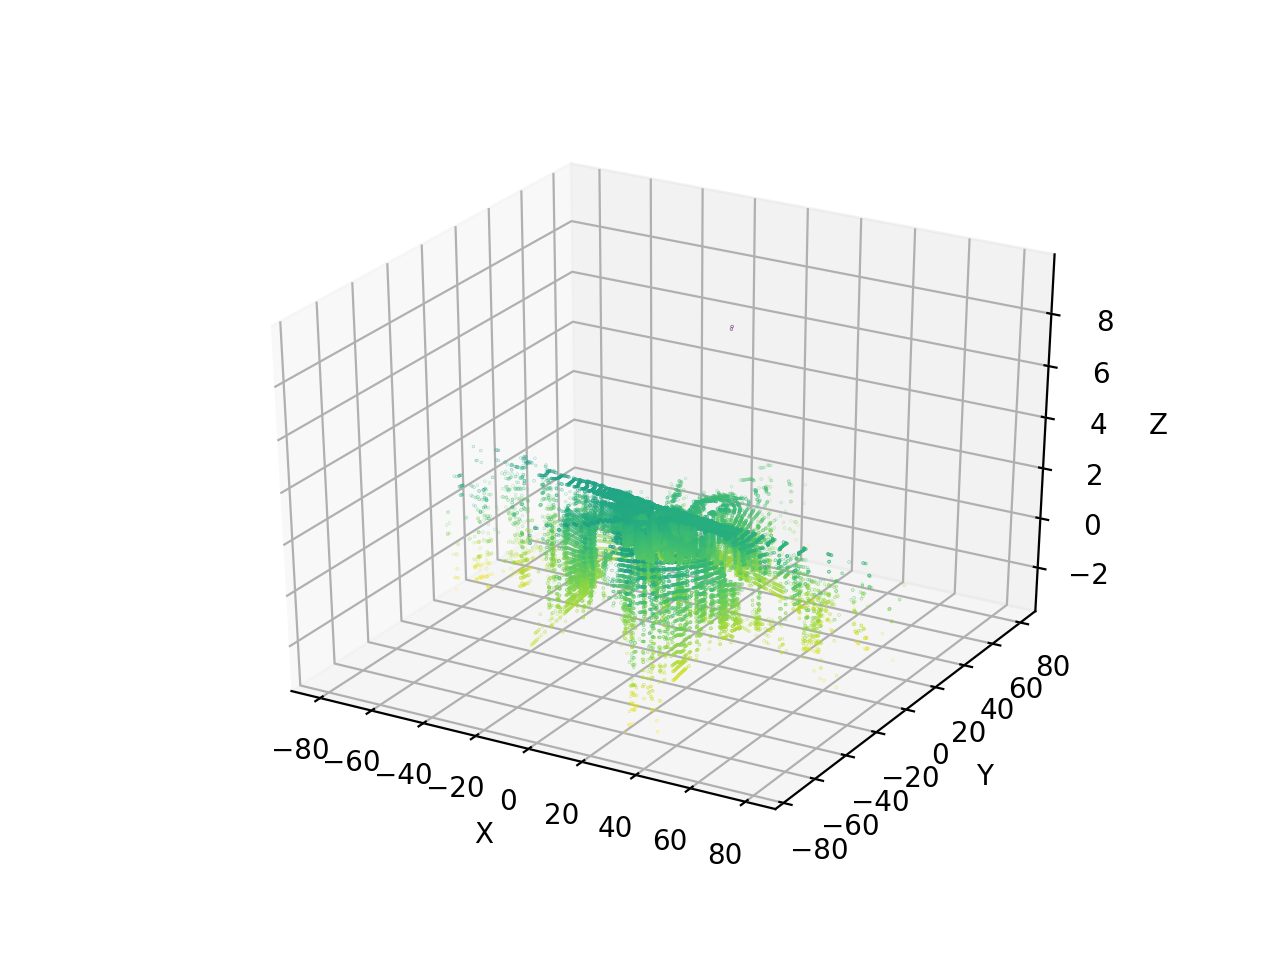

Text(0.5,0,'Z')

In [32]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, -zdata, c=zdata, marker='.', s=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.view_init(,45)

In [6]:
def load_calibration(calib_file):
    calib = [x.strip().split() for x in open(calib_file).readlines()]
    P0 = np.array([float(i) for i in calib[0][1:]]).reshape((3,4))
    P1 = np.array([float(i) for i in calib[1][1:]]).reshape((3,4))
    P2 = np.array([float(i) for i in calib[2][1:]]).reshape((3,4))
    P3 = np.array([float(i) for i in calib[3][1:]]).reshape((3,4))
    R0_rect = np.eye(4, dtype='float32')
    R0_3x3 = np.array([float(i) for i in calib[4][1:]]).reshape((3,3))
    R0_rect[:3,:3] = R0_3x3
    T_v2c = np.eye(4, dtype='float32')
    T_v2c[:3,:] = np.array([float(i) for i in calib[5][1:]]).reshape((3,4))
    T_vel_to_cam = np.dot(R0_rect, T_v2c)
    
    calibs = {'P0': P0, 'P1': P1, 'P2': P2,'P3': P3,
                'R0_rect': R0_rect,
                'T_v2c': T_v2c, 'T_vel_to_cam': T_vel_to_cam}
    return calibs

# def load_calibration(calib_file):
#     calib = [x.strip().split() for x in open(calib_file).readlines()]

#     P1 = np.array(list(map(float, calib[0][1:]))).reshape((3, 4))
#     R1_3x3 = np.array(list(map(float, calib[1][1:]))).reshape((3, 3))
#     R = np.array(list(map(float, calib[2][1:]))).reshape((3, 3))
#     t = np.array(list(map(float, calib[3][1:]))).reshape((1, 3))

#     R1_rect = np.eye(4, dtype='float32')
#     R1_rect[:3, :3] = R1_3x3

#     T_v2c = np.eye(4, dtype='float32')
#     T_v2c[:3, :3] = R
#     T_v2c[:3, 3] = t
#     T_vel_to_cam = np.dot(R1_rect, T_v2c)

#     calibs = {
#         'P1': P1,
#         'R1_rect': R1_rect,
#         'R': R,
#         't': t,
#         'T_v2c': T_v2c,
#         'T_vel_to_cam': T_vel_to_cam
#     }
#     return calibs

In [33]:
calib_file = os.path.join(root_dir, 'calib', example_id+'.txt')
calibs = load_calibration(calib_file)
type(calibs['P1'])

numpy.ndarray

In [67]:
# def label_to_bbox3d(labels):
#     N = len(labels)
#     ret = np.zeros((N, 8, 3), dtype=np.float32)
    
#     for i in range(N):
#         box = labels[i]
#         translation = box[4:7]
#         [l, w, h] = box[1:4]
#         rotation = [0, 0, box[-1]]
#         trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet
#             [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
#             [w/2, -w/2,-w/2, w/2,  w/2, -w/2,-w/2, w/2],
#             [h/2, h/2, h/2,  h/2,  -h/2,-h/2,-h/2, -h/2]
#         ])

#         # re-create 3D bounding box in velodyne coordinate system
#         yaw = rotation[2]
                
#         rotMat = np.array([
#             [np.cos(yaw),  np.sin(yaw), 0], 
#             [-np.sin(yaw),  np.cos(yaw), 0],
#             [0,            0,           1]
#         ])
        
#         cornerPosInVelo = np.dot(trackletBox.T, rotMat) + np.tile(translation, (8, 1))
# #         box3d = cornerPosInVelo.transpose()
                
#         ret[i] = cornerPosInVelo
#     return ret

def label_to_bbox3d(labels):
    N = len(labels)
    ret = np.zeros((N, 8, 3), dtype=np.float32)
    
    for i in range(N):
        box = labels[i]
        translation = box[4:7]
        [h, w, l] = box[1:4]
        rotation = [0, 0, box[-1]]
        trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet
            [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2], \
            [0,0,0,0,-h,-h,-h,-h], \
            [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]])

        # re-create 3D bounding box in velodyne coordinate system
        yaw = rotation[2]
        rotMat = np.array([[np.cos(yaw), 0, np.sin(yaw)],
                          [0, 1, 0], 
                          [-np.sin(yaw), 0, np.cos(yaw)]])
        cornerPosInVelo = np.dot(rotMat, trackletBox) + \
            np.tile(translation, (8, 1)).T
        box3d = cornerPosInVelo.transpose()
        ret[i] = box3d
    return ret

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [-70.4, 70.4], # X axis range
    [-40, 40], # Y axis range
    [-10, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = np.transpose(vertices)[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)


In [69]:
def display_single_lidar(data, boxes=None, points=0.2, view=False):
    # points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, data.shape[0], points_step)
    
    print(points_step)
    print(point_size)
    print(velo_range)

    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(data[:, axes]), s=point_size, c=data[:, 3], cmap='gray')
        
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        
        for i in range(boxes.shape[0]):
            draw_box(ax, boxes[i], axes=axes, color='green')
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(10, 5))
    ax2 = f2.add_subplot(111, projection='3d')   
    ax2.view_init(45,45)
    
    # Hide grid lines
    ax2.grid(False)
#     plt.axis('off')
    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=axes_limits[0])
    plt.show()
    
    if view:    
        # Draw point cloud data as plane projections
        f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
#         axe3.view_init(35,100)
        draw_point_cloud(
            ax3[0], 
            'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right', 
            axes=[0, 2] # X and Z axes
        )
        draw_point_cloud(
            ax3[1], 
            'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
            axes=[0, 1] # X and Y axes
        )
        draw_point_cloud(
            ax3[2], 
            'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane', 
            axes=[1, 2] # Y and Z axes
        )
        plt.show()

In [70]:
labels = os.path.join(root_dir, 'label_2', example_id+'.txt')

In [71]:
pos_cls = ['Car']
ign_cls = ['Van', 'Truck', 'Tram']

In [72]:
def parse_label(labels):
    with open(labels, 'r') as fin:
        ret = []
        for line in fin.readlines():
            [cls, truncated, occluded, alpha, lt_x, lt_y, rb_x, rb_y, h, w, l, x, y, z, rotation_y] = line.split(' ')
            # if cls in pos_cls: # or  cls in ign_cls
            ret.append([cls, float(h), float(w), float(l), float(x), float(y), float(z), float(rotation_y)])
        return ret

lbl = parse_label(labels)


In [82]:
bbox3d = label_to_bbox3d(lbl)

In [83]:
print(lbl)
print(bbox3d.shape)

[['Car', 1.56, 1.57, 4.37, -6.96, 1.73, 7.83, -3.13], ['Car', 1.65, 1.68, 3.88, -6.88, 1.77, 12.36, 3.05], ['Car', 2.08, 1.8, 4.37, -7.14, 1.75, 14.97, -0.04], ['Cyclist', 1.59, 0.58, 1.69, -3.29, 1.78, 24.09, 1.53], ['Car', 1.54, 1.75, 3.36, 6.04, 1.68, 5.65, 0.04], ['Car', 1.48, 1.52, 3.33, 5.79, 1.63, 8.47, 0.01], ['Car', 1.5, 1.58, 2.81, 5.88, 1.68, 11.09, -0.08], ['Car', 1.57, 1.68, 3.97, 5.77, 1.75, 13.6, 3.08], ['Car', 1.44, 1.65, 4.26, 5.6, 1.72, 16.48, -0.07], ['Car', 1.77, 1.69, 3.82, 5.72, 1.75, 18.85, -0.04], ['Car', 1.49, 1.59, 4.44, -7.12, 1.78, 26.03, 3.12], ['Car', 1.48, 1.63, 4.1, -6.79, 1.78, 28.78, -3.14], ['Car', 1.41, 1.56, 4.08, 1.9, 1.74, 31.98, -1.63], ['Car', 1.43, 1.58, 3.37, 1.47, 1.71, 47.02, -1.59], ['Van', 2.33, 1.96, 6.11, 0.39, 1.83, 93.03, -1.57], ['DontCare', -1.0, -1.0, -1.0, -1000.0, -1000.0, -1000.0, -10.0]]
(16, 8, 3)


In [84]:
def project_camera2velo(vel_data_c, calibs):
    # vel_data_c: col 0: back -> front
    #             col 1: down -> up
    #             col 2: left -> right
    
    vel_data = np.hstack((vel_data_c[:, :3], np.ones((vel_data_c.shape[0], 1), dtype='float32')))
    vel_data = np.dot(vel_data, np.linalg.inv(calibs['T_vel_to_cam'].T))
    # vel_data /= vel_data[:, -1].reshape((-1, 1))
    # vel_data = np.hstack((vel_data[:, :3], vel_data_c[:, -1].reshape((-1, 1))))

    return vel_data[:, :3]

In [85]:
bbox3d_lidar = []
for box in bbox3d:
    box = project_camera2velo(box, calibs)
    bbox3d_lidar.append(box)

In [86]:
bbox3d_lidar = np.array(bbox3d_lidar)
bbox3d_lidar.shape

(16, 8, 3)

In [87]:
# def label_to_bbox3d(labels):
#     N = len(labels)
#     ret = np.zeros((N, 8, 3), dtype=np.float32)
    
#     for i in range(N):
#         box = labels[i]
#         translation = box[4:7]
#         size = box[1:4]
#         rotation = [0, 0, box[-1]]
#         h, w, l = size[0], size[1], size[2]
#         trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet
#             [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2], \
#             [-w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2], \
#             [0, 0, 0, 0, -h, -h, -h, -h]])

#         # re-create 3D bounding box in velodyne coordinate system
#         yaw = rotation[2]
#         rotMat = np.array([[np.cos(yaw), np.sin(yaw), 0.0],
#                            [-np.sin(yaw), np.cos(yaw), 0.0], [0.0, 0.0, 1.0]])
#         cornerPosInVelo = np.dot(rotMat, trackletBox) + \
#             np.tile(translation, (8, 1)).T
#         box3d = cornerPosInVelo.transpose()
#         ret[i] = box3d
#     return ret


In [88]:
# bbox3d = label_to_bbox3d(lbl)

In [89]:
bbox3d.shape

(16, 8, 3)

100
1.0
range(0, 110736, 100)


<IPython.core.display.Javascript object>


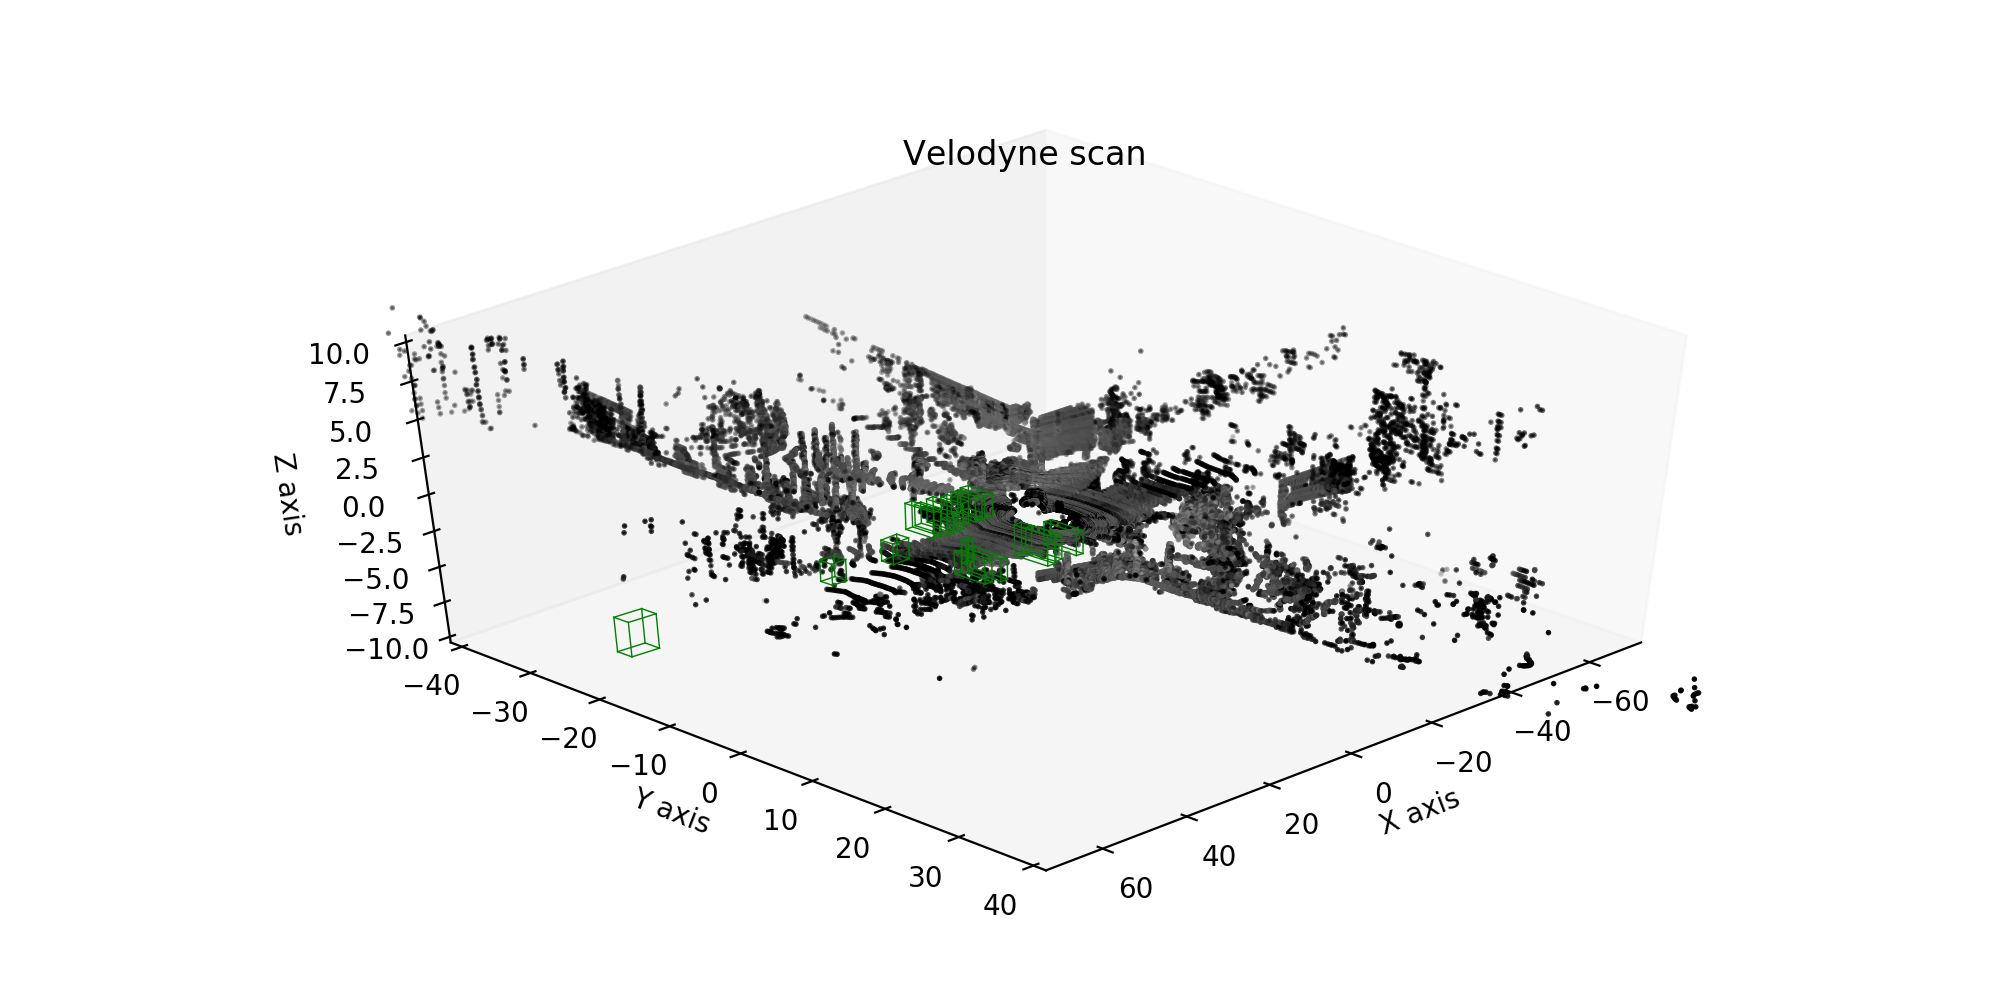

<IPython.core.display.Javascript object>


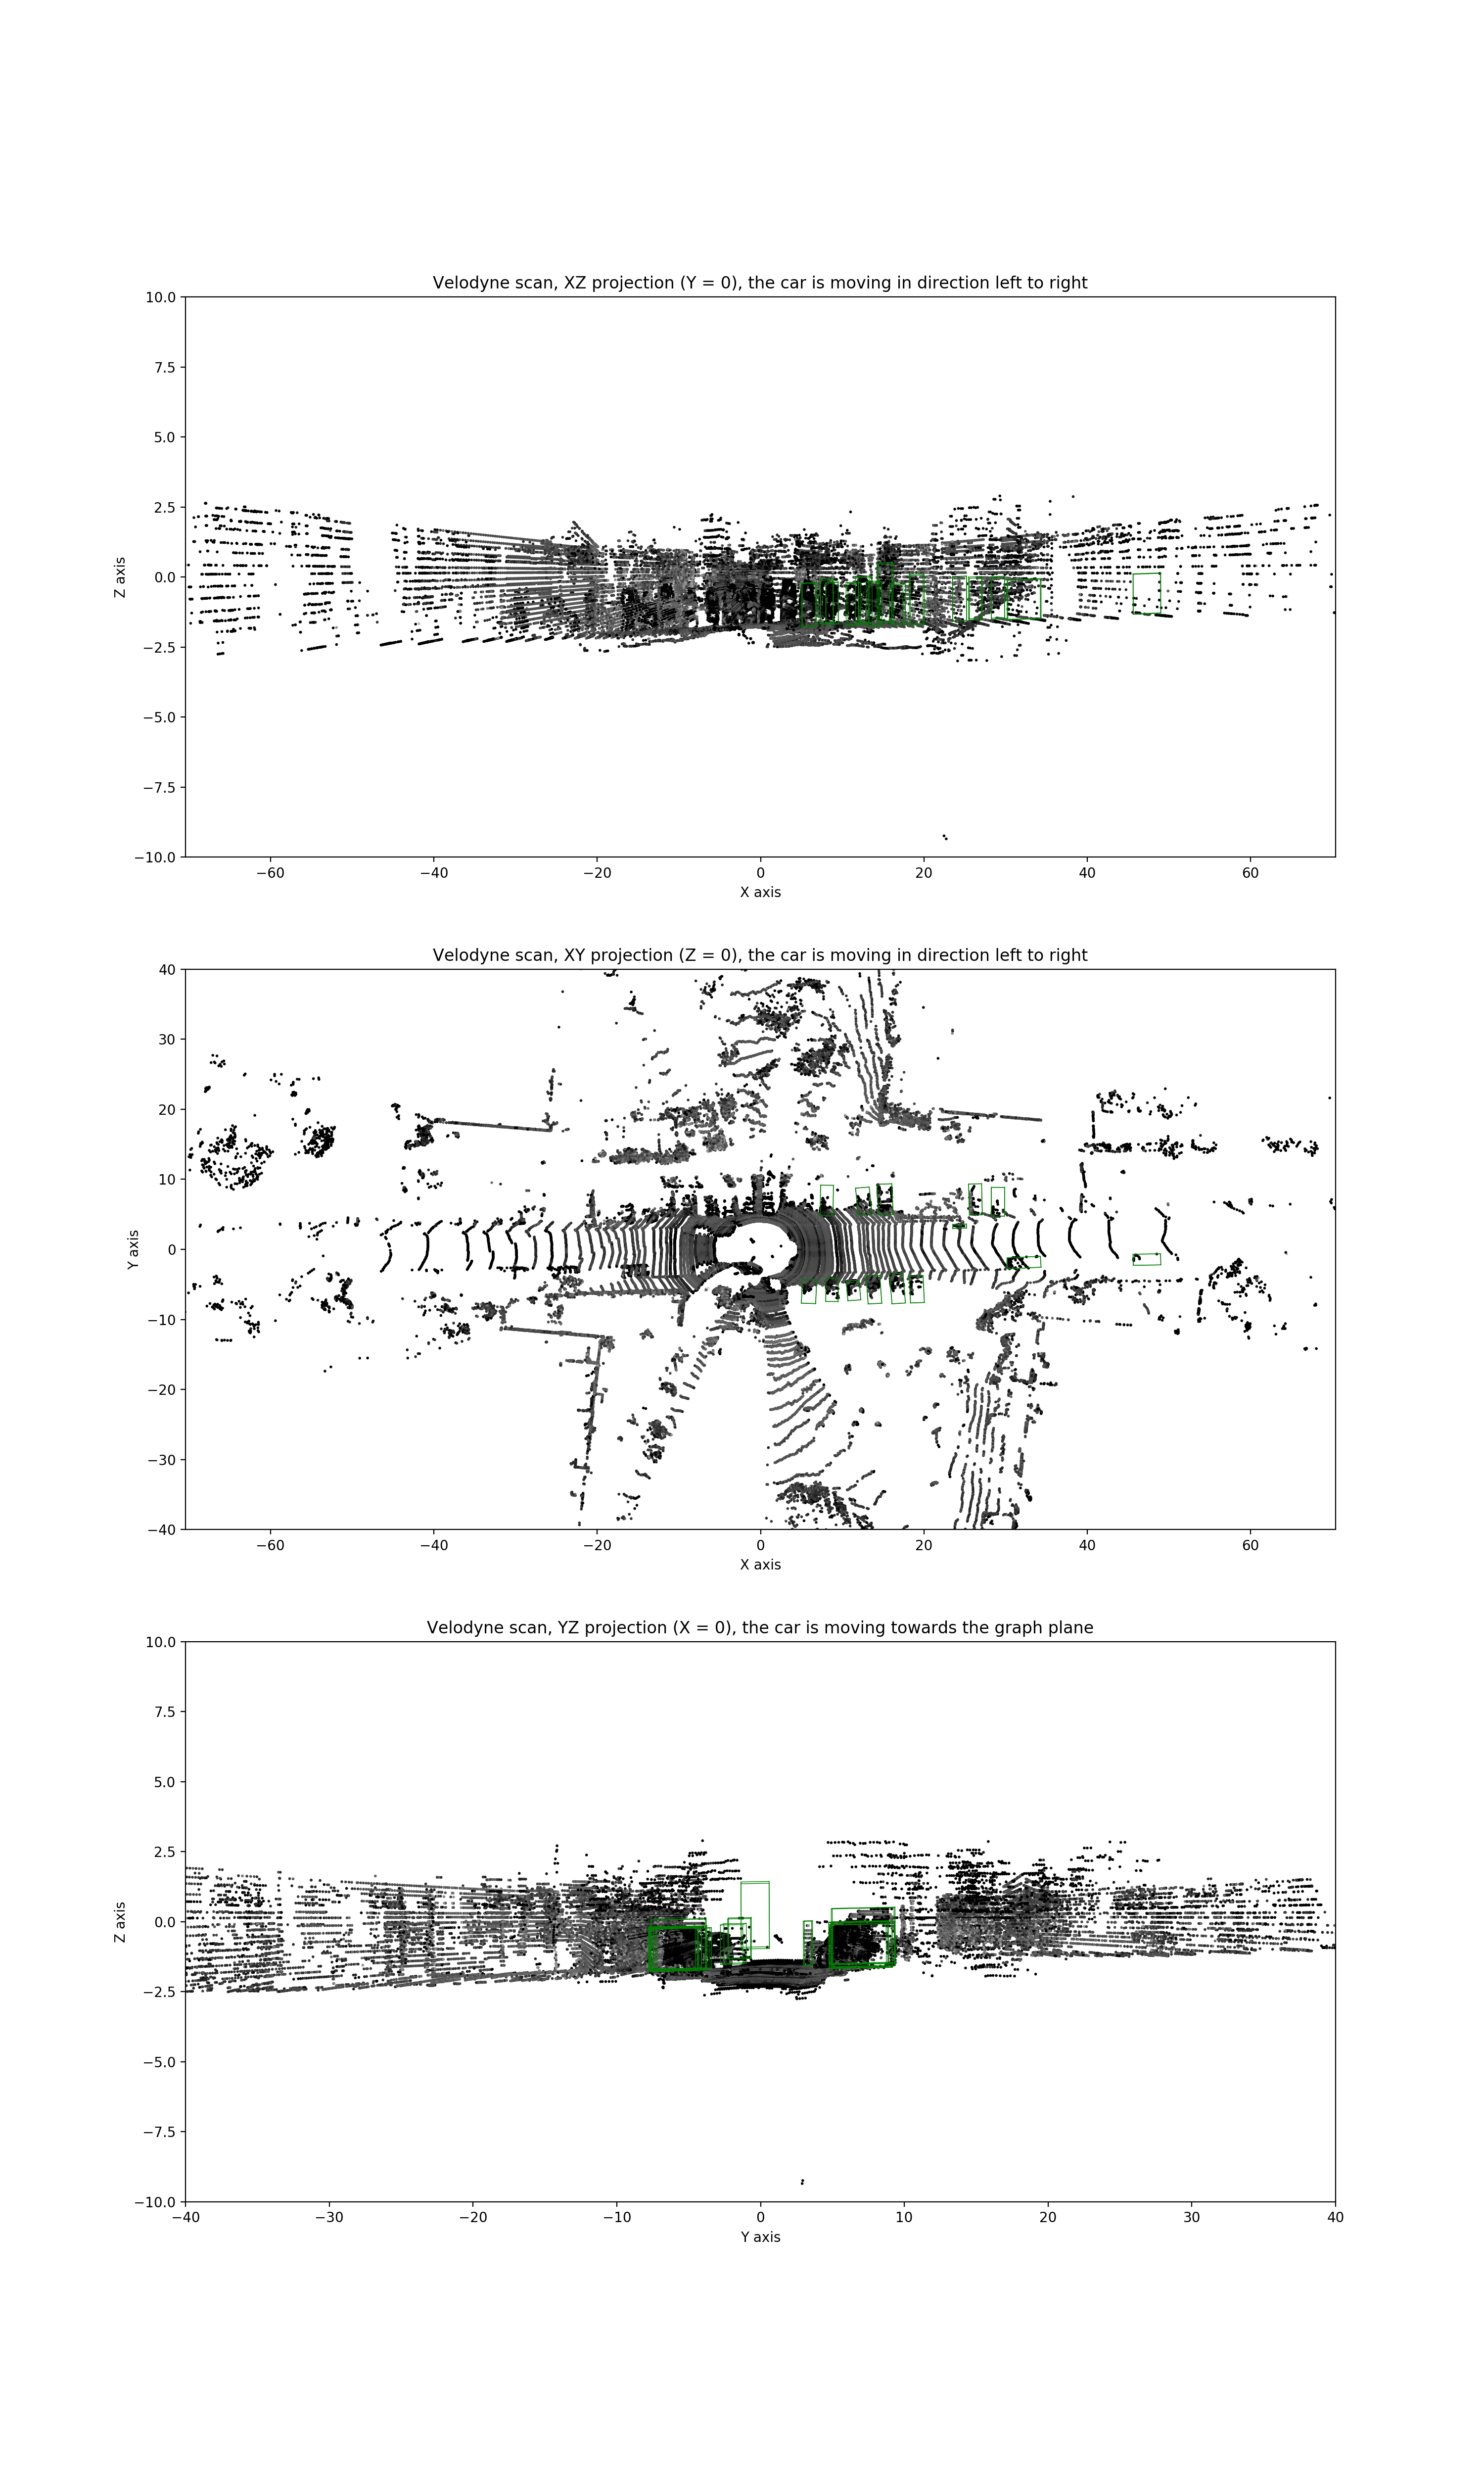

In [91]:
display_single_lidar(raw_lidar, bbox3d_lidar, points=.01, view=True)

In [92]:
CORNER2CENTER_AVG = False
import math

def corner_to_center_box3d(boxes_corner):
    # (N, 8, 3) -> (N, 7) x,y,z,h,w,l,ry/z
    ret = []
    boxes_corner = boxes_corner[:, :, [1, 2, 0]]
    for roi in boxes_corner:
        if CORNER2CENTER_AVG:  # average version
            roi = np.array(roi)
            h = abs(np.sum(roi[:4, 1] - roi[4:, 1]) / 4)
            w = np.sum(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[3, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[1, [0, 2]] - roi[2, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[7, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[5, [0, 2]] - roi[6, [0, 2]])**2))) / 4
            l = np.sum(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[1, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[2, [0, 2]] - roi[3, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[5, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[6, [0, 2]] - roi[7, [0, 2]])**2))) / 4
            x = np.sum(roi[:, 0], axis=0) / 8
            y = np.sum(roi[0:4, 1], axis=0) / 4
            z = np.sum(roi[:, 2], axis=0) / 8
            ry = np.sum(
                math.atan2(roi[2, 0] - roi[1, 0], roi[2, 2] - roi[1, 2]) +
                math.atan2(roi[6, 0] - roi[5, 0], roi[6, 2] - roi[5, 2]) +
                math.atan2(roi[3, 0] - roi[0, 0], roi[3, 2] - roi[0, 2]) +
                math.atan2(roi[7, 0] - roi[4, 0], roi[7, 2] - roi[4, 2]) +
                math.atan2(roi[0, 2] - roi[1, 2], roi[1, 0] - roi[0, 0]) +
                math.atan2(roi[4, 2] - roi[5, 2], roi[5, 0] - roi[4, 0]) +
                math.atan2(roi[3, 2] - roi[2, 2], roi[2, 0] - roi[3, 0]) +
                math.atan2(roi[7, 2] - roi[6, 2], roi[6, 0] - roi[7, 0])) / 8
            if w > l:
                w, l = l, w
#                 ry = angle_in_limit(-ry - np.pi / 2) no need to transfer as it in camera coordinate
        else:  # max version
            h = max(abs(roi[:4, 1] - roi[4:, 1]))
            w = np.max(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[3, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[1, [0, 2]] - roi[2, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[7, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[5, [0, 2]] - roi[6, [0, 2]])**2)))
            l = np.max(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[1, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[2, [0, 2]] - roi[3, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[5, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[6, [0, 2]] - roi[7, [0, 2]])**2)))
            x = np.sum(roi[:, 0], axis=0) / 8
            y = np.sum(roi[0:4, 1], axis=0) / 4
            z = np.sum(roi[:, 2], axis=0) / 8
            ry = np.sum(
                math.atan2(roi[2, 0] - roi[1, 0], roi[2, 2] - roi[1, 2]) +
                math.atan2(roi[6, 0] - roi[5, 0], roi[6, 2] - roi[5, 2]) +
                math.atan2(roi[3, 0] - roi[0, 0], roi[3, 2] - roi[0, 2]) +
                math.atan2(roi[7, 0] - roi[4, 0], roi[7, 2] - roi[4, 2]) +
                math.atan2(roi[0, 2] - roi[1, 2], roi[1, 0] - roi[0, 0]) +
                math.atan2(roi[4, 2] - roi[5, 2], roi[5, 0] - roi[4, 0]) +
                math.atan2(roi[3, 2] - roi[2, 2], roi[2, 0] - roi[3, 0]) +
                math.atan2(roi[7, 2] - roi[6, 2], roi[6, 0] - roi[7, 0])) / 8
            if w > l:
                w, l = l, w


#                 ry = angle_in_limit(-ry - np.pi / 2)
        ret.append([z, x, y, h, w, l,
                    -ry])  # here (0, 1, 2) in camera ---> (2, 0, 1) in lidar

    return np.array(ret)
        

In [93]:
bbox3d_lidar_7 = corner_to_center_box3d(bbox3d_lidar)

In [94]:
bbox3d_lidar_7

array([[ 8.11076927e+00,  6.96865368e+00, -1.64673924e+00,
         1.55982780e+00,  6.27966642e+00,  1.74790020e+01,
         1.58220953e+00],
       [ 1.26404877e+01,  6.88916826e+00, -1.64023554e+00,
         1.64981771e+00,  6.71956348e+00,  1.55192919e+01,
         1.47902415e+00],
       [ 1.52478285e+01,  7.14699554e+00, -1.59021342e+00,
         2.07977033e+00,  7.19957590e+00,  1.74791031e+01,
        -1.61097584e+00],
       [ 2.43711090e+01,  3.30124998e+00, -1.56556356e+00,
         1.58982432e+00,  2.31988096e+00,  6.75960493e+00,
        -4.09757616e-02],
       [ 5.93352222e+00, -6.03131533e+00, -1.75685382e+00,
         1.53982985e+00,  6.99964809e+00,  1.34391899e+01,
        -1.53097580e+00],
       [ 8.75310040e+00, -5.78118992e+00, -1.67474580e+00,
         1.47983658e+00,  6.07967472e+00,  1.33192425e+01,
        -1.56097582e+00],
       [ 1.13733959e+01, -5.87043667e+00, -1.69830859e+00,
         1.49983430e+00,  6.31960011e+00,  1.12394733e+01,
        -1.6509759

In [ ]:
[['Car', 1.48, 1.51, 4.35, 0.55, 1.83, 14.93, 1.92],
 ['Car', 1.47, 1.68, 3.88, 4.24, 1.79, 17.29, 1.94],
 ['Car', 1.46, 1.74, 3.99, 0.44, 1.67, 9.57, 2.1],
 ['Car', 1.42, 1.68, 4.29, 2.69, 1.82, 20.21, 1.95],
 ['Car', 1.36, 1.4, 3.8, 5.6, 1.81, 27.22, 1.96],
 ['Car', 1.44, 1.65, 2.96, 10.61, 1.89, 39.54, 1.87]]

In [95]:
lbl\

[['Car', 1.56, 1.57, 4.37, -6.96, 1.73, 7.83, -3.13],
 ['Car', 1.65, 1.68, 3.88, -6.88, 1.77, 12.36, 3.05],
 ['Car', 2.08, 1.8, 4.37, -7.14, 1.75, 14.97, -0.04],
 ['Cyclist', 1.59, 0.58, 1.69, -3.29, 1.78, 24.09, 1.53],
 ['Car', 1.54, 1.75, 3.36, 6.04, 1.68, 5.65, 0.04],
 ['Car', 1.48, 1.52, 3.33, 5.79, 1.63, 8.47, 0.01],
 ['Car', 1.5, 1.58, 2.81, 5.88, 1.68, 11.09, -0.08],
 ['Car', 1.57, 1.68, 3.97, 5.77, 1.75, 13.6, 3.08],
 ['Car', 1.44, 1.65, 4.26, 5.6, 1.72, 16.48, -0.07],
 ['Car', 1.77, 1.69, 3.82, 5.72, 1.75, 18.85, -0.04],
 ['Car', 1.49, 1.59, 4.44, -7.12, 1.78, 26.03, 3.12],
 ['Car', 1.48, 1.63, 4.1, -6.79, 1.78, 28.78, -3.14],
 ['Car', 1.41, 1.56, 4.08, 1.9, 1.74, 31.98, -1.63],
 ['Car', 1.43, 1.58, 3.37, 1.47, 1.71, 47.02, -1.59],
 ['Van', 2.33, 1.96, 6.11, 0.39, 1.83, 93.03, -1.57],
 ['DontCare', -1.0, -1.0, -1.0, -1000.0, -1000.0, -1000.0, -10.0]]